In [ ]:
import preprocess
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
from matplotlib.colors import BoundaryNorm
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVD, SVDpp, NMF
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split

# Sparsity

In [3]:
# mydict = preprocess.create_paper_paper_dict()
# Creat random subset of dictionary, where we only retain references to themselves
random_dict = preprocess.create_random_subset_paper_paper_data(debug=True)

In [4]:
numbering, reverse = dict(), dict()
current_id = 0

for i in random_dict.keys():
    numbering[i] = current_id
    reverse[current_id] = i
    current_id += 1

In [5]:
# Build paper-paper matrix to observe its sparsity
papernum = len(random_dict.keys())
papermat = sp.dok_matrix((papernum,papernum), dtype=np.int8)
for paper_id, ref_ids in random_dict.items():
    for ref in ref_ids:
        papermat[numbering[paper_id], numbering[ref]] = 1

sparsity:  6.49620491573e-05 %


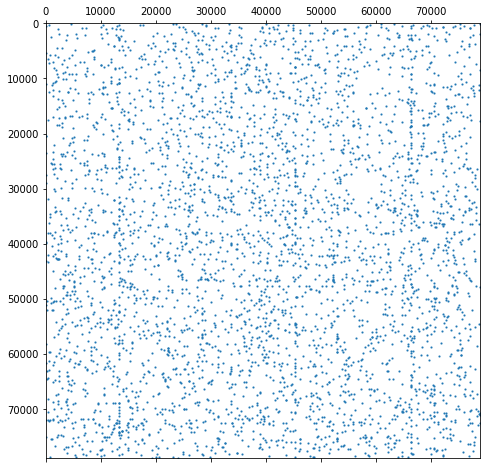

In [6]:
print("sparsity: ",100*papermat.count_nonzero()/papernum**2, "%")
plt.spy(papermat, markersize=1)
plt.show()

# SVD

In [5]:
data = preprocess.create_surprise_paper_paper_data(random_dict)

In [ ]:
# split that data to train, test set and then do SVD
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(biased=False)
algo.fit(trainset)
predictions = algo.test(testset)
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [ ]:
# Comment out following code if not using --
#  https://github.com/MelodyShih/Surprise/tree/1003-project
loss = algo.losshistory
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(loss)), loss, '-o')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid(True)

In [10]:
df[1:5]

,uid,iid,rui,est,details
1,ef09a604-fb66-4c54-9c04-4a5e670718c7,d19e9c93-9bb8-4936-9275-c7fbff937079,1.0,1,"{'was_impossible': True, 'reason': 'User and i..."
2,2d30c813-2412-4efa-adc4-3fd6e8f59109,7e8a055e-3d46-4953-9bb2-f8c5098e2b81,1.0,1,"{'was_impossible': True, 'reason': 'User and i..."
3,b9335ed3-53e6-4f8c-baab-669c9daab9c4,a8d7be47-d1dd-4e4e-9f98-eef55401cfee,1.0,1,"{'was_impossible': True, 'reason': 'User and i..."
4,44cf235f-cbc8-4b0d-9d37-48e3d2901846,450d1f7a-44ba-412d-a394-f24cc28bc6b4,1.0,1,"{'was_impossible': True, 'reason': 'User and i..."


In [11]:
pu = algo.pu
qi = algo.qi
Abar = np.dot(pu, np.transpose(qi))

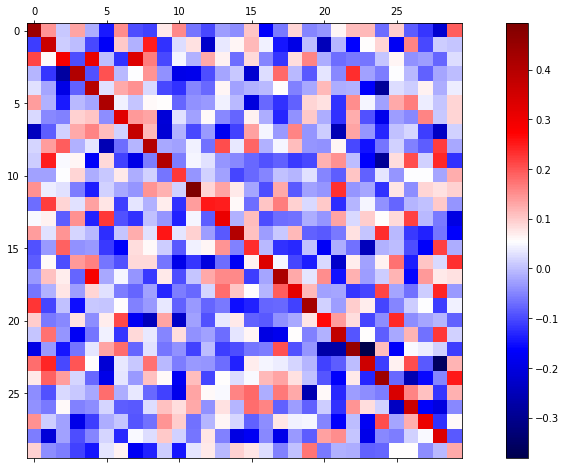

In [12]:
fig, axes = plt.subplots()
min_val, max_val = -2, 2

# define the colormap
# cmap = plt.get_cmap('PuOr')
# cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize and forcing 0 to be part of the colorbar!
# bounds = np.arange(np.min(Abar),np.max(Abar),.5)
# idx=np.searchsorted(bounds,0)
# bounds=np.insert(bounds,idx,0)
# norm = BoundaryNorm(bounds, cmap.N)

pos = axes.matshow(Abar[0:30, 0:30], cmap='seismic')
# pos = axes.matshow(Abar[0:30, 0:30], cmap=cmap, norm=norm)
fig.colorbar(pos)